# Wyjaśnialne uczenie maszynowe, Praca domowa nr 1.
### Piotr Krzywicki, 394 395

Rozwiązujemy klasyczny problem regresji cen mieszkań: https://github.com/pbiecek/InterpretableMachineLearning2020/issues/6

Dane: https://www.kaggle.com/harlfoxem/housesalesprediction

### Wczytanie i podgląd danych nt. mieszkań

In [1]:
import pandas as pd
df = pd.read_csv('kc_house_data.csv')
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


### Wizualizacja najważniejszych parametrów mieszkania
Rozkłady cech: "price", "bedrooms", "squares" przypominają z wyglądu rozkład Gamma (szybkie spiętrzenie od zera i długie ogony)

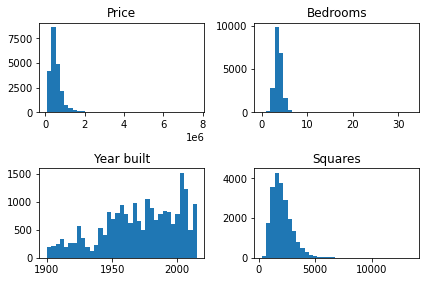

In [2]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2)
n_bins = 35
axs[0, 0].hist(df['price'], bins=n_bins)
axs[0, 0].set_title('Price')
axs[0, 1].hist(df['bedrooms'], bins=n_bins)
axs[0, 1].set_title('Bedrooms')
axs[1, 0].hist(df['yr_built'], bins=n_bins)
axs[1, 0].set_title('Year built')
axs[1, 1].hist(df['sqft_living'], bins=n_bins)
axs[1, 1].set_title('Squares')
fig.tight_layout(pad=1.0)

### Wizualizacja korelacji między cechami
Najbardziej interesująca jest oczywiście korelacja z cechą objaśnianą, tj. "price".

Cecha ta jest najbardziej skorelowana z metrażem, liczbą łazienek, stanem mieszkania, posiadaniem piwnicy i ilością pokoi.

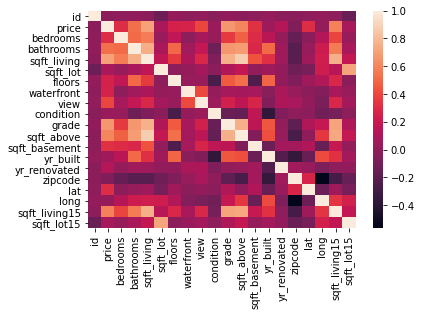

In [3]:
import seaborn as sn

sn.heatmap(df.corr())
plt.show()

### Usunięcie niepożądanych cech i normalizacja danych

In [4]:
del df['id']
del df['date']
del df['zipcode']
del df['lat']
del df['long']

In [5]:
from sklearn import preprocessing
X = preprocessing.MinMaxScaler().fit_transform(df.values)

### Wizualizacja PCA w 3 wymiarach znormalizowanego zbioru
Brak istotnej podstruktury, podklas. 

Jenakże zbiór zrzutowany na 3 wymiary w sposób opisywany przez algorytm PCA wydaje się mieć strukturę dwuwymiarowej rozmaitości.

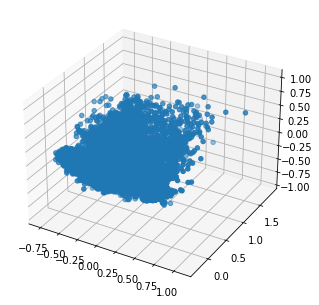

In [6]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition

fig = plt.figure()
ax = Axes3D(fig)

pca = decomposition.PCA(n_components=3)
pca.fit(X)
X_viz = pca.transform(X)

ax.scatter(X_viz[:, 0], X_viz[:, 1], X_viz[:, 2])

### Podział na zbiory: treningowy i testowy

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X[:, 1:], X[:, 0], test_size=0.2)

### Konstrukcja i podsumowanie modelu
Używamy arbitralnej architektury sieci z trzema warstwami gęstymi po 256 neuronów, aktywacją relu oraz warstwami dropout z $p=0.5$.

In [8]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow
import tensorflow as tf

batchsize = 512
model = Sequential([
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation=None),
])

model.compile(
    loss='mae',
    optimizer='adam',
    metrics=[
        tf.keras.metrics.RootMeanSquaredError(),
        tf.keras.metrics.MeanSquaredError(),
        tf.keras.metrics.MeanAbsoluteError(),
    ],
)

model.build(input_shape=(batchsize, 15))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (512, 256)                4096      
_________________________________________________________________
dropout (Dropout)            (512, 256)                0         
_________________________________________________________________
dense_1 (Dense)              (512, 256)                65792     
_________________________________________________________________
dropout_1 (Dropout)          (512, 256)                0         
_________________________________________________________________
dense_2 (Dense)              (512, 256)                65792     
_________________________________________________________________
dropout_2 (Dropout)          (512, 256)                0         
_________________________________________________________________
dense_3 (Dense)              (512, 1)                  2

### Trening parametrów modelu
Trenujemy sieć używając algorytmu SGD z rozmiarem batcha równym 512 przez 10 przejść po zbiorze treningowym.

In [9]:
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), batch_size=batchsize, epochs=400, verbose=0
)

### Podsumowanie wyników
Udało się zredukować średni błąd bezwzględny ponad dwukrotnie w stosunku do modelu zainicjowanego losowo, otrzymując średni błąd bezwzględny na poziomie 150000.

Nie jest to mało, ale biorąc pod uwagę odchylenie standardowe ceny wynoszące 367118.7, widzimy, że model się czegoś nauczył.

Z wykresów widać, że błąd na zbiorze testowym stabilizuje się po około 100 epokach.

Oczywiście to jest tylko demonstracja – na zajęciach poproszono, by w tym zadaniu użyć typu modeli, który się najbardziej lubi, nie zważając zbytnio na dopasowanie do wybranych z puli dostępnych zadań.

Do tego typu danych zgodnie z teraźniejszą wiedzą powinien zostać model lasów losowych,

najlepiej oparty o framework gradient boosting – np. xgboost, bądź lightgbm. 

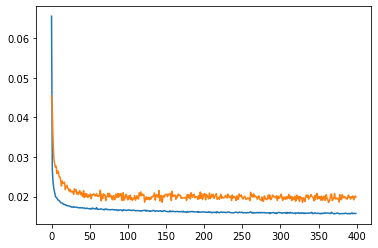

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

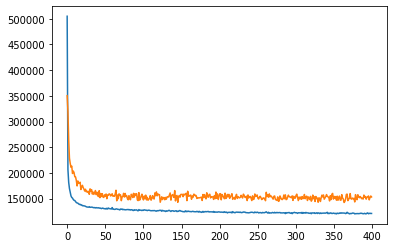

In [12]:
import numpy as np
plt.plot(np.array(history.history['mean_absolute_error']) * np.max(df['price']))
plt.plot(np.array(history.history['val_mean_absolute_error']) * np.max(df['price']))

In [13]:
np.mean(df['price'])

540088.1417665294

In [14]:
np.std(df['price'])

367118.7031813722